<a href="https://colab.research.google.com/github/DrSunday1405/Fault-Diagnosis-Using-Hybrid-Transfer-Learning-for-VNF-based-5G-Core-Networks/blob/main/MLP_based_feature_selection_(20240524_%E5%88%92%E5%88%86%E6%95%B0%E6%8D%AE%E9%9B%86%E5%B9%B6%E4%B8%94%E9%AA%8C%E8%AF%81%E8%AE%AD%E7%BB%83%E5%A4%9A%E5%B0%91%E4%B8%AA_epoch%E5%90%88%E9%80%82).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

这个代码仔细主要是验证 训练多少个 epoch 最合适

In [ ]:
print(torch.__version__)

2.3.0+cu121


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_raw_tab_A = pd.read_csv('drive/My Drive/2023_KDDI_challenge_digtal twin_dataset/train_data_A.csv')
data_raw_tab_C_train = pd.read_csv('drive/My Drive/2023_KDDI_challenge_digtal twin_dataset/train_data_C.csv')
data_raw_tab_C_test = pd.read_csv('drive/My Drive/2023_KDDI_challenge_digtal twin_dataset/test_data_C.csv')
data_raw_tab_A.head()

,time,source_name,y_true(fc),amfx1_ens3_oper-status,amfx1_ens3_phys-address,amfx1_ens3_speed,amfx1_ens3_statistics.in-octets,amfx1_ens3_statistics.in-unicast-pkts,amfx1_ens3_statistics.out-octets,amfx1_ens3_statistics.out-unicast-pkts,...,upfx7_memory-stats.free-percent_value,upfx7_memory-stats.memory-status_value,upfx7_memory-stats.used-number_value,upfx7_memory-stats.used-percent_value,upfx7_per-core-stats.per-core-stat.idle_value,upfx7_per-core-stats.per-core-stat.io-wait_value,upfx7_per-core-stats.per-core-stat.nice_value,upfx7_per-core-stats.per-core-stat.sirq_value,upfx7_per-core-stats.per-core-stat.system_value,upfx7_per-core-stats.per-core-stat.user_value
0,20210128175112-4_20210128175200,network-5gc-a,udmx1_vcpu-overload-start,0,0,0,1,1,1,1,...,0,0,-3308,0,-0.22,0.030,0,0.0,-0.030,0.24
1,20210128175529-6_20210128175610,network-5gc-a,normal,0,0,0,1,1,1,1,...,-4,0,79536,4,0.07,-0.055,0,0.0,0.095,-0.11
2,20210128175945-8_20210128180030,network-5gc-a,normal,0,0,0,1,1,1,1,...,0,0,-3756,0,0.09,0.000,0,0.0,0.090,-0.28
3,20210128180403-10_20210128180450,network-5gc-a,udmx1_ens4_interface-loss-start-70,0,0,0,1,1,1,1,...,-4,0,85520,4,0.05,0.050,0,0.0,0.050,-0.15
4,20210128180817-12_20210128180900,network-5gc-a,normal,0,0,0,1,1,1,1,...,0,0,-5044,0,0.31,-0.150,0,0.0,-0.100,-0.11


In [ ]:
data_raw_tab_C_train.head()

,time,source_name,y_true(fc),amfx1_ens3_oper-status,amfx1_ens3_phys-address,amfx1_ens3_speed,amfx1_ens3_statistics.in-octets,amfx1_ens3_statistics.in-unicast-pkts,amfx1_ens3_statistics.out-octets,amfx1_ens3_statistics.out-unicast-pkts,...,upfx7_memory-stats.free-percent_value,upfx7_memory-stats.memory-status_value,upfx7_memory-stats.used-number_value,upfx7_memory-stats.used-percent_value,upfx7_per-core-stats.per-core-stat.idle_value,upfx7_per-core-stats.per-core-stat.io-wait_value,upfx7_per-core-stats.per-core-stat.nice_value,upfx7_per-core-stats.per-core-stat.sirq_value,upfx7_per-core-stats.per-core-stat.system_value,upfx7_per-core-stats.per-core-stat.user_value
0,20210128175112-4_20210128175200,network-5gc-c,normal,0,0,0,1,1,1,1,...,8,0,-148496,-8,-0.095,0.18,0,0.0,0.045,-4.500000e-02
1,20210128175529-6_20210128175610,network-5gc-c,udmx1_vcpu-overload-start,0,0,0,1,1,1,1,...,0,0,-24,0,-0.095,0.02,0,0.0,0.010,8.000000e-02
2,20210128175945-8_20210128180030,network-5gc-c,amfx1_memory-stress-start,0,0,0,1,1,1,1,...,-1,0,4092,1,-0.100,0.00,0,0.0,0.100,4.160000e-17
3,20210128180403-10_20210128180450,network-5gc-c,normal,0,0,0,1,1,1,1,...,0,0,244,0,0.350,-0.02,0,0.0,-0.030,-3.100000e-01
4,20210128180817-12_20210128180900,network-5gc-c,normal,0,0,0,1,1,1,1,...,0,0,160,0,-0.130,0.00,0,0.0,0.140,-5.000000e-03


In [ ]:
data_raw_tab_A.dtypes    # check the data type for each column

time                                                 object
source_name                                          object
y_true(fc)                                           object
amfx1_ens3_oper-status                                int64
amfx1_ens3_phys-address                               int64
                                                     ...   
upfx7_per-core-stats.per-core-stat.io-wait_value    float64
upfx7_per-core-stats.per-core-stat.nice_value         int64
upfx7_per-core-stats.per-core-stat.sirq_value       float64
upfx7_per-core-stats.per-core-stat.system_value     float64
upfx7_per-core-stats.per-core-stat.user_value       float64
Length: 4121, dtype: object

In [ ]:
data_raw_tab_A.describe()

,amfx1_ens3_oper-status,amfx1_ens3_phys-address,amfx1_ens3_speed,amfx1_ens3_statistics.in-octets,amfx1_ens3_statistics.in-unicast-pkts,amfx1_ens3_statistics.out-octets,amfx1_ens3_statistics.out-unicast-pkts,amfx1_ens3_oper-status_value,amfx1_ens3_phys-address_value,amfx1_ens3_speed_value,...,upfx7_memory-stats.free-percent_value,upfx7_memory-stats.memory-status_value,upfx7_memory-stats.used-number_value,upfx7_memory-stats.used-percent_value,upfx7_per-core-stats.per-core-stat.idle_value,upfx7_per-core-stats.per-core-stat.io-wait_value,upfx7_per-core-stats.per-core-stat.nice_value,upfx7_per-core-stats.per-core-stat.sirq_value,upfx7_per-core-stats.per-core-stat.system_value,upfx7_per-core-stats.per-core-stat.user_value
count,3645.0,3645.0,3645.0,3645.0,3645.0,3645.0,3645.0,3645.0,3645.0,3645.0,...,3645.000000,3645.0,3645.000000,3645.000000,3645.000000,3645.000000,3645.0,3645.000000,3645.000000,3645.000000
mean,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.032647,0.0,-939.736626,-0.032647,0.002632,0.009392,0.0,0.000571,-0.001115,-0.014742
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.003434,0.0,60210.989674,3.003434,1.298748,0.876834,0.0,0.033653,0.174028,0.611928
min,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,-12.000000,0.0,-240232.000000,-12.000000,-55.085000,-10.515000,0.0,-0.200000,-7.655000,-34.610000
25%,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,-2.000000,0.0,-34500.000000,-2.000000,-0.135000,-0.070000,0.0,0.000000,-0.070000,-0.105000
50%,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.000000,0.0,28.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,2.000000,0.0,34320.000000,2.000000,0.130000,0.060000,0.0,0.000000,0.070000,0.100000
max,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,12.000000,0.0,239980.000000,12.000000,53.805000,50.640000,0.0,0.200000,2.555000,1.835000


In [ ]:
# check the distributin of label column
fig=px.histogram(data_raw_tab_A,
        x="y_true(fc)",
        hover_data=data_raw_tab_A.columns,
        title="Each label Ratio in the train_data_A")
fig.show()

流式输出内容被截断，只能显示最后 5000 行内容。
/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_output[col_name] = to_unindexed_series(df_input[argument])
/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_output[col_name] = to_unindexed_series(df_input[argument])
/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

In [ ]:
# Checking for NULLs in the data
null_count = data_raw_tab_A.isnull().sum()
print(type(null_count))
print(null_count.nunique())
print(null_count)

<class 'pandas.core.series.Series'>
1
time                                                0
source_name                                         0
y_true(fc)                                          0
amfx1_ens3_oper-status                              0
amfx1_ens3_phys-address                             0
                                                   ..
upfx7_per-core-stats.per-core-stat.io-wait_value    0
upfx7_per-core-stats.per-core-stat.nice_value       0
upfx7_per-core-stats.per-core-stat.sirq_value       0
upfx7_per-core-stats.per-core-stat.system_value     0
upfx7_per-core-stats.per-core-stat.user_value       0
Length: 4121, dtype: int64


In [ ]:
# Remove the mutual columns that contain only one value from train_A and train_C
train_A_col_n1 = []
train_C_col_n1 = []
common_col_n1 = []

for col in data_raw_tab_A.columns:
  if data_raw_tab_A[col].nunique() == 1:
    train_A_col_n1.append(col)
print(len(train_A_col_n1))
print(train_A_col_n1)
print("\n")

for col in data_raw_tab_C_train.columns:
  if data_raw_tab_C_train[col].nunique() == 1:
    train_C_col_n1.append(col)
print(len(train_C_col_n1))
print(train_C_col_n1)
print("\n")

for i in train_A_col_n1:
  if i in train_C_col_n1:
    common_col_n1.append(i)
print(len(common_col_n1))
print(common_col_n1)

data_raw_tab_A = data_raw_tab_A.drop(columns=common_col_n1)
data_raw_tab_C_train = data_raw_tab_C_train.drop(columns=common_col_n1)
data_raw_tab_C_test = data_raw_tab_C_test.drop(columns=common_col_n1)

data_raw_tab_A.head()

2191
['source_name', 'amfx1_ens3_oper-status', 'amfx1_ens3_phys-address', 'amfx1_ens3_speed', 'amfx1_ens3_statistics.in-octets', 'amfx1_ens3_statistics.in-unicast-pkts', 'amfx1_ens3_statistics.out-octets', 'amfx1_ens3_statistics.out-unicast-pkts', 'amfx1_ens3_oper-status_value', 'amfx1_ens3_phys-address_value', 'amfx1_ens3_speed_value', 'amfx1_ens4_oper-status', 'amfx1_ens4_phys-address', 'amfx1_ens4_speed', 'amfx1_ens4_oper-status_value', 'amfx1_ens4_phys-address_value', 'amfx1_ens4_speed_value', 'amfx1_ens5_phys-address', 'amfx1_ens5_statistics.out-octets', 'amfx1_ens5_statistics.out-unicast-pkts', 'amfx1_ens5_oper-status_value', 'amfx1_ens5_phys-address_value', 'amfx1_ens5_speed_value', 'amfx1_lo_oper-status', 'amfx1_lo_phys-address', 'amfx1_lo_speed', 'amfx1_lo_oper-status_value', 'amfx1_lo_phys-address_value', 'amfx1_lo_speed_value', 'ausfx1_ens3_oper-status', 'ausfx1_ens3_phys-address', 'ausfx1_ens3_speed', 'ausfx1_ens3_statistics.in-octets', 'ausfx1_ens3_statistics.in-unicast-pk

,time,y_true(fc),amfx1_ens3_statistics.in-octets_value,amfx1_ens3_statistics.in-unicast-pkts_value,amfx1_ens3_statistics.out-octets_value,amfx1_ens3_statistics.out-unicast-pkts_value,amfx1_ens4_statistics.in-octets,amfx1_ens4_statistics.in-unicast-pkts,amfx1_ens4_statistics.out-octets,amfx1_ens4_statistics.out-unicast-pkts,...,upfx7_memory-stats.committed-percent_value,upfx7_memory-stats.free-number_value,upfx7_memory-stats.free-percent_value,upfx7_memory-stats.used-number_value,upfx7_memory-stats.used-percent_value,upfx7_per-core-stats.per-core-stat.idle_value,upfx7_per-core-stats.per-core-stat.io-wait_value,upfx7_per-core-stats.per-core-stat.sirq_value,upfx7_per-core-stats.per-core-stat.system_value,upfx7_per-core-stats.per-core-stat.user_value
0,20210128175112-4_20210128175200,udmx1_vcpu-overload-start,100146,1505,2550911,2254,1,1,1,1,...,0,3308,0,-3308,0,-0.22,0.030,0.0,-0.030,0.24
1,20210128175529-6_20210128175610,normal,107778,1619,2562513,2332,1,1,1,1,...,0,-79536,-4,79536,4,0.07,-0.055,0.0,0.095,-0.11
2,20210128175945-8_20210128180030,normal,102906,1547,2561033,2301,1,1,1,1,...,0,3756,0,-3756,0,0.09,0.000,0.0,0.090,-0.28
3,20210128180403-10_20210128180450,udmx1_ens4_interface-loss-start-70,45348,676,700993,732,1,1,1,1,...,-1,-85520,-4,85520,4,0.05,0.050,0.0,0.050,-0.15
4,20210128180817-12_20210128180900,normal,105734,1583,2549200,2291,1,1,1,1,...,0,5044,0,-5044,0,0.31,-0.150,0.0,-0.100,-0.11


In [ ]:
# 这个 advanced task 先别管，这个是当时 KDDI 的任务，和你现在的研究无关

# # Try to conduct the advanced task later, which is using only 10% of the training data from domain C

# # Split the dataset into normal and abnormal data
# normal_data = data_raw_tab_C_train[data_raw_tab_C_train['y_true(fc)'] == "normal"]
# abnormal_data = data_raw_tab_C_train[data_raw_tab_C_train['y_true(fc)'] != "normal"]

# print("Testing the data separation from noraml and abnormal")
# print(normal_data)
# print("\n")
# print(abnormal_data)

# # Change the data from data_train_C we use to train by adjusting the value: frac. When frac is 1.0, we use 100% of train_data_C
# sampled_data = normal_data.sample(frac=1.0, random_state=42)
# for label in abnormal_data['y_true(fc)'].unique():
#     label_data = abnormal_data[abnormal_data['y_true(fc)'] == label]
#     sampled_data = pd.concat([sampled_data, label_data.sample(frac=1.0, random_state=42)])

# # Reset the index
# sampled_data.reset_index(drop=True, inplace=True)
# data_raw_tab_C_train = sampled_data.sample(frac=1, random_state=42)

# # sampled_data now contains the 10% subset of the original dataset with balanced class distribution.

In [ ]:
fig=px.histogram(data_raw_tab_C_train,
        x="y_true(fc)",
        hover_data=data_raw_tab_C_train.columns,
        title="Each label Ratio in the sample data")
fig.show()

流式输出内容被截断，只能显示最后 5000 行内容。
/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

In [ ]:
# 要在这里划分好数据集（训练和验证），不然后面很难用“fig=px.histogram"这个函数去观察划分结果，然后我决定了，val_A 和 val_C 都必须保持各个标签的样本数是均匀的，每个标签取样20%
# train_A, val_A = train_test_split(data_raw_tab_A, test_size=0.2, random_state=42)
# train_C, val_C = train_test_split(data_raw_tab_C_train, test_size=0.2)   由于data_raw_tab_C_train数量太少，直接划分有一些标签没能成功划到验证集


# Domain A
# Split the dataset into normal and abnormal data
normal_data = data_raw_tab_A[data_raw_tab_A['y_true(fc)'] == "normal"]
abnormal_data = data_raw_tab_A[data_raw_tab_A['y_true(fc)'] != "normal"]

print("Testing the data separation from noraml and abnormal")
print(normal_data)
print("\n")
print(abnormal_data)

# Change the data from data_train_C we use to train by adjusting the value: frac. When frac is 1.0, we use 100% of train_data_C
sampled_data_train_A, sampled_data_val_A = train_test_split(normal_data, test_size=0.2, random_state=42)
# print("测试一下")
for label in abnormal_data['y_true(fc)'].unique():
    label_data = abnormal_data[abnormal_data['y_true(fc)'] == label]
    # print(label_data.shape)
    # print(label_data['y_true(fc)'])
    # print("\n")
    label_train_A, label_val_A = train_test_split(label_data, test_size=0.2, random_state=42)
    # print("看看每个标签的划分结果")
    # print(label_val_C['y_true(fc)'])
    # print("\n")
    sampled_data_train_A = pd.concat([sampled_data_train_A, label_train_A])
    sampled_data_val_A = pd.concat([sampled_data_val_A, label_val_A])
    # print(sampled_data_val_C.shape)
    # print("\n")

# Reset the index
sampled_data_train_A.reset_index(drop=True, inplace=True)
train_A = sampled_data_train_A.sample(frac=1, random_state=42)
sampled_data_val_A.reset_index(drop=True, inplace=True)
val_A = sampled_data_val_A.sample(frac=1, random_state=42)



# Domain C
# Split the dataset into normal and abnormal data
normal_data = data_raw_tab_C_train[data_raw_tab_C_train['y_true(fc)'] == "normal"]
abnormal_data = data_raw_tab_C_train[data_raw_tab_C_train['y_true(fc)'] != "normal"]

print("Testing the data separation from noraml and abnormal")
print(normal_data)
print("\n")
print(abnormal_data)

# Change the data from data_train_C we use to train by adjusting the value: frac. When frac is 1.0, we use 100% of train_data_C
sampled_data_train_C, sampled_data_val_C = train_test_split(normal_data, test_size=0.2, random_state=42)
# print("测试一下")
for label in abnormal_data['y_true(fc)'].unique():
    label_data = abnormal_data[abnormal_data['y_true(fc)'] == label]
    # print(label_data.shape)
    # print(label_data['y_true(fc)'])
    # print("\n")
    label_train_C, label_val_C = train_test_split(label_data, test_size=0.2, random_state=42)
    # print("看看每个标签的划分结果")
    # print(label_val_C['y_true(fc)'])
    # print("\n")
    sampled_data_train_C = pd.concat([sampled_data_train_C, label_train_C])
    sampled_data_val_C = pd.concat([sampled_data_val_C, label_val_C])
    # print(sampled_data_val_C.shape)
    # print("\n")

# Reset the index
sampled_data_train_C.reset_index(drop=True, inplace=True)
train_C = sampled_data_train_C.sample(frac=1, random_state=42)
sampled_data_val_C.reset_index(drop=True, inplace=True)
val_C = sampled_data_val_C.sample(frac=1, random_state=42)


Testing the data separation from noraml and abnormal
                                   time y_true(fc)  \
1       20210128175529-6_20210128175610     normal   
2       20210128175945-8_20210128180030     normal   
4      20210128180817-12_20210128180900     normal   
5      20210128181232-14_20210128181320     normal   
6      20210128181646-16_20210128181730     normal   
...                                 ...        ...   
3639  20210215052639-957_20210215052720     normal   
3640  20210215053100-959_20210215053150     normal   
3641  20210215053518-961_20210215053600     normal   
3643  20210215054357-965_20210215054440     normal   
3644  20210215054815-967_20210215054900     normal   

      amfx1_ens3_statistics.in-octets_value  \
1                                    107778   
2                                    102906   
4                                    105734   
5                                    101478   
6                                    103164   
...             

In [ ]:
fig=px.histogram(val_A,
        x="y_true(fc)",
        hover_data=val_A.columns,
        title="Each label Ratio in the sample data")
fig.show()

流式输出内容被截断，只能显示最后 5000 行内容。
/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

In [ ]:
fig=px.histogram(val_C,
        x="y_true(fc)",
        hover_data=val_C.columns,
        title="Each label Ratio in the sample data")
fig.show()

流式输出内容被截断，只能显示最后 5000 行内容。
/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

In [ ]:
print(train_A)

                                   time                  y_true(fc)  \
178    20210128183353-24_20210128183440                      normal   
678   20210128222022-131_20210128222110                      normal   
2873  20210130154607-335_20210130154650   amfx1_vcpu-overload-start   
2686  20210203054103-836_20210203054150  ausfx1_vcpu-overload-start   
1898  20210206132320-183_20210206132410                      normal   
...                                 ...                         ...   
1638  20210201140755-683_20210201140840                      normal   
1095  20210202141016-396_20210202141100                      normal   
1130  20210212191149-545_20210212191230                      normal   
1294  20210131234555-274_20210131234640                      normal   
860   20210201125545-648_20210201125630                      normal   

      amfx1_ens3_statistics.in-octets_value  \
178                                  101508   
678                                   87496   
2873  

In [ ]:
# Separate the labels and features in the dataset and transform them into proper data type

X_train_A = train_A.iloc[:,2:]
y_train_A = train_A.iloc[:,1]
X_val_A = val_A.iloc[:,2:]
y_val_A = val_A.iloc[:,1]

X_train_C = train_C.iloc[:,2:]
y_train_C = train_C.iloc[:,1]
X_val_C = val_C.iloc[:,2:]
y_val_C = val_C.iloc[:,1]
X_test_C = data_raw_tab_C_test.iloc[:,2:]
y_test_C = data_raw_tab_C_test.iloc[:,1]


print(X_train_C)
print("\n")
print(y_test_C)


     amfx1_ens3_statistics.in-octets_value  \
165                                  54968   
33                                   55460   
15                                   45900   
312                                 192559   
57                                   58968   
..                                     ...   
71                                   54620   
106                                  71280   
270                                  51296   
348                                  56466   
102                                  52322   

     amfx1_ens3_statistics.in-unicast-pkts_value  \
165                                          820   
33                                           828   
15                                           686   
312                                         1183   
57                                           884   
..                                           ...   
71                                           816   
106                            

In [ ]:
# Conduct data preprocessing of Min-Max scaling
scaler_A = preprocessing.MinMaxScaler()
scaler_A.fit(X_train_A)
X_train_A = scaler_A.transform(X_train_A)
X_train_A = pd.DataFrame(X_train_A)
X_val_A = scaler_A.transform(X_val_A)
X_val_A = pd.DataFrame(X_val_A)

scaler_C = preprocessing.MinMaxScaler()
scaler_C.fit(X_train_C)
X_train_C = scaler_C.transform(X_train_C)
X_val_C = scaler_C.transform(X_val_C)
X_test_C = scaler_C.transform(X_test_C)


X_train_C = pd.DataFrame(X_train_C)
X_val_C = pd.DataFrame(X_val_C)
X_test_C = pd.DataFrame(X_test_C)

print(X_test_C)



         0         1         2         3     4     5     6     7         8     \
0    0.279838  0.831169  0.837944  0.870906   0.0   0.0   0.0   0.0  0.600248   
1    0.277398  0.824242  0.842498  0.862235   0.0   0.0   0.0   0.0  0.606120   
2    0.279502  0.831169  0.830190  0.876686   0.0   0.0   0.0   0.0  0.601663   
3    0.811723  0.534199  0.046510  0.157033   0.0   0.0   0.0   0.0  0.030952   
4    0.220648  0.682251  0.827409  0.734104   0.0   0.0   0.0   0.0  0.589671   
..        ...       ...       ...       ...   ...   ...   ...   ...       ...   
868  0.705711  0.137662  0.067420  0.119461   0.0   0.0   0.0   0.0  0.047683   
869  0.081150  0.204329  0.503373  0.429672   0.0   0.0   0.0   0.0  0.366714   
870  0.083479  0.209524  0.501541  0.449904   0.0   0.0   0.0   0.0  0.366961   
871  0.141697  0.355844  0.824246  0.737958   0.0   0.0   0.0   0.0  0.594906   
872  0.146713  0.367100  0.838177  0.746628   0.0   0.0   0.0   0.0  0.596675   

         9     ...  1925   

In [ ]:
# Encode the labels

encoder = preprocessing.LabelEncoder()
y_train_A = encoder.fit_transform(y_train_A)
y_val_A = encoder.fit_transform(y_val_A)
y_train_C = encoder.fit_transform(y_train_C)
y_val_C = encoder.fit_transform(y_val_C)
y_test_C = encoder.fit_transform(y_test_C)


print("After encoding the label:")
print(y_train_A)
print(type(y_train_A))
print(len(y_train_A))
print("\n")

print("检查输出")

print(y_test_C.shape)
print(y_test_C)



After encoding the label:
[10 10  4 ... 10 10 10]
<class 'numpy.ndarray'>
2913


检查输出
(873,)
[10 10 10  1 10 10 10 14 10 10 10 10  4 10  9 10  5  6 10 10  8 10 10 10
 10 15 12 10 10 10 10  0 11 10 10 13 10 10 10 10 10  3 10  7  2 10 10 10
 10 10 10 10 10 10 10 10 10 10 10  8 10 10  7 10 10  6 10  5 12 10 10 10
 14  2 10 10 10 10  0 10 11  9 10  4 15 13  1 10 10 10  3 10  5 10 10  8
 10 12 14 10 10 10  3 10 10 10 10 10  0 11 10 10  6 10 10 10 10  2 10  4
 10 13  7 10 10 10  9 10 10 10 10 10 10  1 10 10 10 15 10  3 10 10 10  1
 10  6 10  9 10  0 10 10  7 10 10 10 10 10 10 10 15 11  8 10 10 10 10 10
 14 10 10  5 10 10 12 10  2 10 13 10 10 10 10  4  7 10 10 10  1 10 10  2
  5 15 10 10 10 10 10  9  4 12 10 10 14  8 10 10 10 10 10 13 10 10 10 10
 10 10 10 11 10 10  3 10 10 10 10  0  6 10  3 10  2 10 10 10 10 10 10 10
 10  8 10 10  0 10 10 10 10 10 15 11 10 10 10 13 10 10 10 14 10 10 10  6
  4 10  1 10 10  5  7 10 12 10 10  9  2 10 10  9  0 13  8  6 10 10  1  5
 10 15 10 10 10 10 10 10 10 10 

In [ ]:
X_val_A.head()

,0,1,2,3,4,5,6,7,8,9,...,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934
0,0.009581,0.199050,0.538473,0.360335,1.0,1.0,1.0,1.0,0.585290,0.583072,...,0.526316,0.497213,0.500000,0.502787,0.500000,0.512490,0.168670,0.5,0.759549,0.932913
1,0.007123,0.128300,0.550524,0.377405,1.0,1.0,1.0,1.0,0.602114,0.598746,...,0.473684,0.497665,0.500000,0.502335,0.500000,0.506842,0.162129,0.5,0.764447,0.950885
2,0.003284,0.058254,0.220763,0.131285,1.0,1.0,1.0,1.0,0.163463,0.152038,...,0.526316,0.740318,0.750000,0.259682,0.250000,0.510653,0.171695,0.5,0.738492,0.938949
3,0.007754,0.139740,0.690174,0.428926,1.0,1.0,1.0,1.0,0.745447,0.742947,...,0.473684,0.497766,0.500000,0.502234,0.500000,0.505877,0.171940,0.5,0.754652,0.948278
4,0.013176,0.237064,0.903019,0.661080,1.0,1.0,1.0,1.0,0.956456,0.959248,...,0.473684,0.571941,0.583333,0.428059,0.416667,0.504730,0.172431,0.5,0.751714,0.952257


In [ ]:
# Select the mutual features from domain A and domain C according to their mutual information
# The most important part in this project, which is even more time-consuming than model training process


t0 = time.time()
k_best_A = SelectKBest(score_func=mutual_info_classif, k=280)
# By changing the value K, we can evaluate the performance when we use different number of selected features
temp_X_A = pd.concat([X_train_A, X_val_A], axis=0, ignore_index=True)
temp_Y_A = np.concatenate((y_train_A, y_val_A), axis=0)
print(temp_X_A.shape)
print(temp_Y_A.shape)


X_new_A = k_best_A.fit_transform(temp_X_A, temp_Y_A)


t1 = time.time()
print("Time for domain A")
print(t1 - t0)
print("\n")

selected_features_A = k_best_A.get_support(indices=True)
print("Selected feature indices for domain A:\n", selected_features_A)
print("\n")

t0 = time.time()
k_best_C = SelectKBest(score_func=mutual_info_classif, k=280)

temp_X_C = pd.concat([X_train_C, X_val_C], axis=0, ignore_index=True)
temp_Y_C = np.concatenate((y_train_C, y_val_C), axis=0)
print(temp_X_C.shape)
print(temp_Y_C.shape)
X_new_C = k_best_C.fit_transform(temp_X_C, temp_Y_C)

# print("After feature selection:")
# print(type(X_new))
# print(X_new)
# print("\n")

t1 = time.time()
print("Time for domain C")
print(t1 - t0)
print("\n")

selected_features_C = k_best_C.get_support(indices=True)
print("Selected feature indices for domain C:\n", selected_features_C)
print("\n")



(3645, 1935)
(3645,)
Time for domain A
63.455124855041504


Selected feature indices for domain A:
 [   0    1    2    3    8    9   10   11   12   13   14   18   19   20
   21   22   23   24   25   26   27   28   29   30   31   32   33   34
   35   37   40   41   42   43   44   45   46   47   48   49   50   51
  172  181  187  205  217  258  268  277  308  310  316  332  338  345
  404  405  407  409  410  424  444  445  464  469  470  474  475  479
  485  507  509  513  518  523  528  556  569  582  596  599  600  610
  621  633  641  652  656  667  679  680  683  684  693  694  695  696
  697  698  699  703  704  705  706  707  708  712  713  714  715  716
  717  719  720  721  722  723  724  736  754  769  784  822  847  881
  884  893  946  985  987  992  995  996  997 1004 1005 1006 1007 1008
 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022
 1023 1024 1025 1027 1029 1031 1032 1034 1039 1040 1041 1042 1043 1044
 1045 1046 1047 1048 1049 1050 1051 1052 1053 10

In [ ]:
common_features = np.intersect1d(selected_features_A, selected_features_C)
print(common_features.shape)
input_dim = len(common_features)
print(input_dim)
print(common_features)

(132,)
132
[   0    1    2    3    8    9   10   11   12   13   14   18   19   20
   21   23   24   25   30   31   32   33   34   35   37   40   41   42
   43   44   45   46   47   48   51  469  470  679  683  684  695  696
  703  704  705  706  707  708  712  713  714  715  716  717  719  720
  721  722  723  724  769  985  992  995  996  997 1004 1007 1008 1009
 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1021 1022 1025 1027
 1029 1031 1032 1034 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049
 1050 1051 1054 1055 1270 1364 1366 1371 1479 1584 1589 1591 1593 1594
 1596 1603 1604 1605 1606 1607 1608 1609 1610 1611 1612 1613 1614 1615
 1618 1619 1631 1677 1785 1835]


In [ ]:
X_train_A = X_train_A[common_features]
X_val_A = X_val_A[common_features]

X_train_C = X_train_C[common_features]
X_val_C = X_val_C[common_features]
X_test_C = X_test_C[common_features]

print(X_train_A)
print("\n")
print(X_train_C)
print("\n")

          0         1         2         3         8         9         10    \
0     0.013198  0.237064  0.895416  0.650838  0.952430  0.957680  0.966221   
1     0.011127  0.200810  0.898103  0.610180  0.949698  0.954545  0.910295   
2     0.032053  0.272967  0.904960  0.594972  0.948428  0.956113  0.899651   
3     0.010844  0.195178  0.892888  0.579764  0.956264  0.951411  0.899781   
4     0.009220  0.165787  0.746916  0.497827  0.803154  0.804075  0.770130   
...        ...       ...       ...       ...       ...       ...       ...   
2908  0.015181  0.295671  0.908735  0.663253  0.955234  0.956113  0.971998   
2909  0.014980  0.296902  0.900964  0.642458  0.957199  0.960815  0.958934   
2910  0.013276  0.239528  0.898730  0.662011  0.959955  0.967085  0.972493   
2911  0.014384  0.284407  0.897586  0.621664  0.953556  0.959248  0.955577   
2912  0.014983  0.291799  0.899813  0.649597  0.957271  0.954545  0.979233   

          11    12    13    ...      1612      1613      1614  

In [ ]:
X_train_A.head()

,0,1,2,3,8,9,10,11,12,13,...,1612,1613,1614,1615,1618,1619,1631,1677,1785,1835
0,0.013198,0.237064,0.895416,0.650838,0.952430,0.957680,0.966221,0.950980,0.0,0.0,...,0.942857,0.050648,0.057143,0.653119,0.181088,0.324112,1.0,0.0,0.542857,0.473684
1,0.011127,0.200810,0.898103,0.610180,0.949698,0.954545,0.910295,0.837010,0.0,0.0,...,0.942857,0.050561,0.057143,0.653283,0.179885,0.327750,1.0,0.0,0.714286,0.473684
2,0.032053,0.272967,0.904960,0.594972,0.948428,0.956113,0.899651,0.823529,0.0,0.0,...,0.942857,0.051011,0.057143,0.651310,0.178792,0.329664,1.0,0.0,0.571429,0.473684
3,0.010844,0.195178,0.892888,0.579764,0.956264,0.951411,0.899781,0.812500,0.0,0.0,...,0.942857,0.050355,0.057143,0.650784,0.182017,0.329281,1.0,0.0,0.542857,0.473684
4,0.009220,0.165787,0.746916,0.497827,0.803154,0.804075,0.770130,0.709559,0.0,0.0,...,0.942857,0.050741,0.057143,0.652691,0.175512,0.329568,1.0,0.0,0.485714,0.473684


In [ ]:

print(X_train_C)
# data_input_features_A = pd.DataFrame(X_new)
# data_input_features_A.head()

# selected_features = k_best.get_support(indices=True)
# print("Selected feature indices:", selected_features)

# # data_input_features_A = pd.DataFrame(data_input_features_A[:, selected_features], columns=[data_input_features_A.columns[i] for i in selected_features])
# # print(data_input_features_A)



         0         1         2         3         8         9         10    \
0    0.197753  0.492641  0.843349  0.873796  0.601592  0.618605  0.677206   
1    0.200340  0.499567  0.848770  0.870906  0.602335  0.618605  0.687276   
2    0.150068  0.376623  0.827090  0.718690  0.590768  0.609302  0.598215   
3    0.921280  0.806926  0.538067  0.656069  0.380828  0.395349  0.428294   
4    0.218787  0.548052  0.832626  0.896917  0.601769  0.623256  0.686475   
..        ...       ...       ...       ...       ...       ...       ...   
363  0.195923  0.489177  0.836073  0.884393  0.611390  0.627907  0.690442   
364  0.283530  0.838961  0.839347  0.887283  0.599646  0.616279  0.665688   
365  0.178443  0.445887  0.830736  0.837187  0.592147  0.604651  0.608361   
366  0.205630  0.638961  0.692972  0.662813  0.506367  0.513953  0.541041   
367  0.183838  0.460606  0.820844  0.828516  0.600672  0.618605  0.677931   

         11    12    13    ...  1612      1613  1614      1615      1618  \

In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())

2.3.0+cu121
False


In [ ]:
# 尝试不使用卷积层，就直接使用最普通的全连接神经网络
# class Net(nn.Module):
#   def __init__(self):
#     super(Net, self).__init__()    # 这个super 函数得捣鼓一下，里面要有什么参数

#     self.model = nn.Sequential(
#         nn.Linear(1928, 482, bias=True),
#         nn.Tanh(),     # 话说它这里如何使最终输出是softmax 概率值啊，需要额外编写吗，最好看一下源码
#         nn.Linear(482, 100, bias=True),
#         nn.Tanh(),
#         nn.Linear(100, 50, bias=True),
#         nn.ReLU(),
#         nn.Linear(50, 16, bias=True),
#     )

#   def forward(self, input):
#     x = self.model(input)
#     return x

class MLP_Net(nn.Module):
    def __init__(self):
        super(MLP_Net, self).__init__()
        # self.fc1 = nn.Linear(1000, 512)
        # self.relu = nn.ReLU()
        # self.fc2 = nn.Linear(512, 256)
        # self.fc3 = nn.Linear(256, 16)

        # self.fc1 = nn.Linear(800, 400)
        # self.relu = nn.ReLU()
        # self.fc2 = nn.Linear(400, 200)
        # self.fc3 = nn.Linear(200, 16)
#
        # self.fc1 = nn.Linear(1935, 512)
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 16)

        # self.fc1 = nn.Linear(600, 300)
        # self.relu = nn.ReLU()
        # self.fc2 = nn.Linear(300, 150)
        # self.fc3 = nn.Linear(150, 16)


    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
# Assign the model
model = MLP_Net()

In [ ]:
# Setting the hyperparameter for training in domain A
num_epoch = 100
batch_size = 45
learning_rate = 0.001   # Might need further improvement later
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [ ]:
print(type(X_train_C.values))
print(X_test_C.values)

<class 'numpy.ndarray'>
[[0.27983825 0.83116883 0.83794416 ... 0.         0.45762712 0.5       ]
 [0.27739829 0.82424242 0.84249822 ... 0.         0.54237288 0.5       ]
 [0.2795017  0.83116883 0.83018971 ... 0.         0.49152542 0.5       ]
 ...
 [0.08347926 0.20952381 0.50154144 ... 1.         0.61016949 0.        ]
 [0.14169651 0.35584416 0.82424625 ... 1.         0.52542373 0.        ]
 [0.14671315 0.36709957 0.83817679 ... 1.         0.61016949 0.        ]]


In [ ]:
# Set up the dataset  顺便在这里划分数据集
X_train_A = torch.from_numpy(X_train_A.values)   # The data type of dataframe.value is numpy
y_train_A = torch.from_numpy(y_train_A)
X_val_A = torch.from_numpy(X_val_A.values)   # The data type of dataframe.value is numpy
y_val_A = torch.from_numpy(y_val_A)


print('Before changing the format of data:')
print(X_train_A.size())
print(X_train_A.dtype)
print(y_train_A.size())
print(y_train_A.dtype)

X_train_A = X_train_A.to(torch.float32)
y_train_A = y_train_A.to(torch.float32)
X_val_A = X_val_A.to(torch.float32)
y_val_A = y_val_A.to(torch.float32)

print("After changing the format of data:")
print(X_train_A.size())
print(X_train_A.dtype)
print(y_train_A.size())
print(y_train_A.dtype)
print("\n")

print(X_val_A.size())
print(X_val_A.dtype)
print(y_val_A.size())
print(y_val_A.dtype)



train_A_ds = TensorDataset(X_train_A, y_train_A)
train_A_dl = DataLoader(train_A_ds, batch_size=batch_size, shuffle=True)
val_A_ds = TensorDataset(X_val_A, y_val_A)
val_A_dl = DataLoader(val_A_ds, batch_size=batch_size, shuffle=True)



Before changing the format of data:
torch.Size([2913, 132])
torch.float64
torch.Size([2913])
torch.int64
After changing the format of data:
torch.Size([2913, 132])
torch.float32
torch.Size([2913])
torch.float32


torch.Size([732, 132])
torch.float32
torch.Size([732])
torch.float32


In [ ]:
# 干脆先看看训练集和验证集的数量
print(len(X_train_A))
print("\n")
print(len(y_train_A))

2913


2913


In [ ]:
# 再验证一下验证集的划分

In [ ]:
val_loss_calculate = []
t0 = time.time()
for epoch in range(num_epoch):
  model.train()
  batch_loss = []
  for x,y in train_A_dl:
    optimizer.zero_grad()  # clear the gradient in each iteration
    output = model(x)
    y = y.long()
    loss = criterion(output,y)  # output is the predicted value, y is the true label
    loss.backward()
    optimizer.step()
    # batch_loss.append(loss.data_numpy())

  model.eval()
  val_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for x, y in val_A_dl:
      outputs = model(x)
      y = y.long()
      loss = criterion(outputs, y)
      val_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total += y.size(0)
      correct += (predicted == y).sum().item()
  print(f'Epoch {epoch + 1}/{num_epoch}, Loss: {val_loss / len(val_A_dl)}, Accuracy: {correct / total}')
  val_loss_calculate.append(val_loss / len(val_A_dl))

t1 = time.time()
print("The training time is: {}".format(t1-t0))




Epoch 1/100, Loss: 1.0159241241567276, Accuracy: 0.7363387978142076
Epoch 2/100, Loss: 0.5027569094124962, Accuracy: 0.8715846994535519
Epoch 3/100, Loss: 0.3303099947378916, Accuracy: 0.9098360655737705
Epoch 4/100, Loss: 0.3165898296762915, Accuracy: 0.9139344262295082
Epoch 5/100, Loss: 0.27418044231393757, Accuracy: 0.9221311475409836
Epoch 6/100, Loss: 0.3126751846250366, Accuracy: 0.9153005464480874
Epoch 7/100, Loss: 0.27451417463667255, Accuracy: 0.9316939890710383
Epoch 8/100, Loss: 0.23030240439316807, Accuracy: 0.930327868852459
Epoch 9/100, Loss: 0.23165921954547658, Accuracy: 0.9330601092896175
Epoch 10/100, Loss: 0.21950836654971628, Accuracy: 0.9371584699453552
Epoch 11/100, Loss: 0.2249743580160772, Accuracy: 0.9398907103825137
Epoch 12/100, Loss: 0.2146740921718233, Accuracy: 0.9385245901639344
Epoch 13/100, Loss: 0.19690945262418075, Accuracy: 0.9494535519125683
Epoch 14/100, Loss: 0.20124716004904578, Accuracy: 0.9398907103825137
Epoch 15/100, Loss: 0.179621845045510

[1.0159241241567276, 0.5027569094124962, 0.3303099947378916, 0.3165898296762915, 0.27418044231393757, 0.3126751846250366, 0.27451417463667255, 0.23030240439316807, 0.23165921954547658, 0.21950836654971628, 0.2249743580160772, 0.2146740921718233, 0.19690945262418075, 0.20124716004904578, 0.17962184504551046, 0.18961454204776707, 0.21330244620056713, 0.15945256391868873, 0.1648585991386105, 0.16229436535607367, 0.16858052133637316, 0.2088391375454033, 0.17487812557202928, 0.18797731750151692, 0.17571458439616597, 0.1518529490019907, 0.15543868392705917, 0.13655197532737956, 0.19646931012325428, 0.14203380322193399, 0.132391146658098, 0.16800324728383736, 0.16407990236492717, 0.15028502499027288, 0.1517490142792025, 0.12242739291532952, 0.27954096653882193, 0.1719411059611422, 0.17904622737756548, 0.15337183786665692, 0.13136884822126696, 0.1493627107976114, 0.15873618451330593, 0.152615472811329, 0.13377820629188242, 0.18114436669823, 0.12986668944358826, 0.25229915976524353, 0.206577844

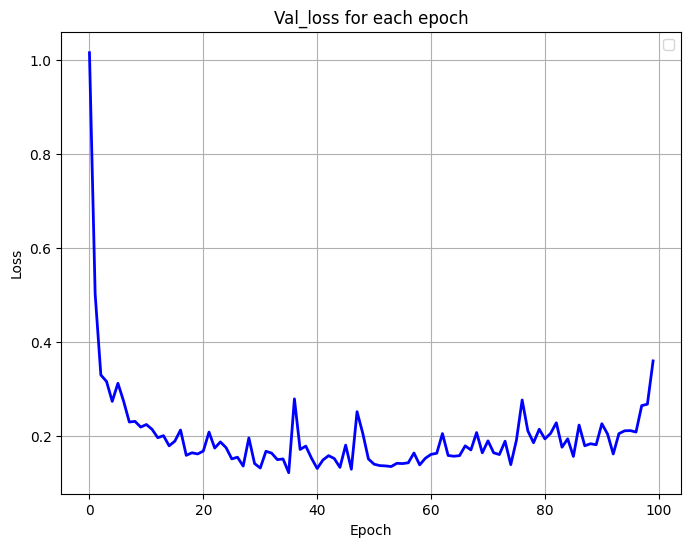

In [ ]:
print(val_loss_calculate)

i = num_epoch
x = np.array(list(range(i)))
y = np.array(val_loss_calculate)

plt.figure(figsize=(8, 6))
plt.plot(x, y, color='b', linewidth=2)
plt.title('Val_loss for each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)

In [ ]:
# Evaluate the performance in training set.
print("The size of encoded label is:")
print(y_val_A.size())
print(y_val_A)
print("\n")

Output = model(X_val_A)
print("The size of output is:")
print(Output.size())
print(Output)
print("\n")

Pred = Output.argmax(axis=1)
print("The size of predicted value is:")
print(Pred.size())
print(Pred)
print("\n")

print("The confusion matrix is:")
print(confusion_matrix(y_val_A, Pred))
print("\n")

print("The f1 score is:")
print(f1_score(y_val_A, Pred, average="micro"))

print("The accuracy is:")
print(f"Train accuracy on train_A.csv: {accuracy_score(y_val_A, Pred) * 100:.2f}%")



The size of encoded label is:
torch.Size([732])
tensor([11., 10., 10., 10.,  0., 12., 10., 10.,  4., 13., 10., 10., 10., 14.,
        10., 10., 10., 10., 10., 10., 11., 10., 10., 10., 10., 10., 10., 15.,
        10.,  4., 10., 10., 10.,  6.,  4., 10.,  6.,  1., 10., 10., 10., 10.,
         1., 10., 10., 10., 10.,  2., 13., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10.,  1., 10.,  7., 10.,  6., 15.,  2.,  7., 10., 10.,  0.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,  4., 10.,  7.,  9.,
        10.,  4., 10., 10., 10., 10., 10., 11.,  9., 10.,  4., 10., 10., 10.,
        10., 10., 10., 10., 11., 10., 10., 11., 10., 10.,  1., 10., 10.,  3.,
        10., 13., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 12.,
        10., 10., 10., 12., 10., 10., 14.,  8., 10., 10., 14., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10.,  9., 10., 10., 10., 10., 10., 10.,
        10., 10., 10.,  7., 10., 10., 10., 10., 10., 14., 10., 10., 10., 10.,
        10., 10.

In [ ]:
# Download the model
# model_Pretrained = Conv_Net()
# model_Pretrained.load_state_dict(torch.load('model_A.pkl'))   # 2023年9月27日再次运行模型发现保存失败了，之后琢磨怎么保存

Start to train the model on domain C ( Beginning of transfer learning)

In [ ]:
# check the distributin of label column
# fig=px.histogram(data_raw_tab_C_train,
#         x="y_true(fc)",
#         hover_data=data_raw_tab_A.columns,
#         title="Each label Ratio in the train_data_C")
# fig.show()

In [ ]:
# Obtain the label encoding dictionary
label_decoded_dict = dict(zip(range(len(encoder.classes_)), encoder.classes_))
print(label_decoded_dict)

{0: 'amfx1_bridge-delif', 1: 'amfx1_ens5_interface-down', 2: 'amfx1_ens5_interface-loss-start-70', 3: 'amfx1_memory-stress-start', 4: 'amfx1_vcpu-overload-start', 5: 'ausfx1_bridge-delif', 6: 'ausfx1_ens4_interface-down', 7: 'ausfx1_ens4_interface-loss-start-70', 8: 'ausfx1_memory-stress-start', 9: 'ausfx1_vcpu-overload-start', 10: 'normal', 11: 'udmx1_bridge-delif', 12: 'udmx1_ens4_interface-down', 13: 'udmx1_ens4_interface-loss-start-70', 14: 'udmx1_memory-stress-start', 15: 'udmx1_vcpu-overload-start'}


In [ ]:
# Setting the hyperparameter for training in domain C
num_epoch = 100
batch_size = 20
learning_rate = 0.001   # Might need further improvement later
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Set up the dataset for domain C in pytorch training
X_train_C = torch.from_numpy(X_train_C.values)
X_val_C = torch.from_numpy(X_val_C.values)
X_test_C = torch.from_numpy(X_test_C.values)
y_train_C = torch.from_numpy(y_train_C)   # The data type of dataframe.value is numpy
y_val_C = torch.from_numpy(y_val_C)
y_test_C = torch.from_numpy(y_test_C)


X_train_C = X_train_C.to(torch.float32)
X_val_C = X_val_C.to(torch.float32)
X_test_C = X_test_C.to(torch.float32)
y_train_C = y_train_C.to(torch.float32)
y_val_C = y_val_C.to(torch.float32)
y_test_C = y_test_C.to(torch.float32)

print(X_train_C.size())
print(X_train_C)
print("\n")
print(y_train_C.size())
print(y_train_C)

train_C_ds = TensorDataset(X_train_C, y_train_C)
train_C_dl = DataLoader(train_C_ds, batch_size=batch_size, shuffle=True)
val_C_ds = TensorDataset(X_val_C, y_val_C)
val_C_dl = DataLoader(val_C_ds, batch_size=batch_size, shuffle=True)

# test_C_ds = TensorDataset(Input_C_test, encoded_label_C_test)
# test_C_dl = DataLoader(test_C_ds, batch_size=batch_size, shuffle=True)   其实 test data 是不需要打包成 dataloader的


torch.Size([368, 132])
tensor([[0.1978, 0.4926, 0.8433,  ..., 1.0000, 0.4915, 1.0000],
        [0.2003, 0.4996, 0.8488,  ..., 0.0000, 0.4068, 0.5000],
        [0.1501, 0.3766, 0.8271,  ..., 0.0000, 0.4915, 0.5000],
        ...,
        [0.1784, 0.4459, 0.8307,  ..., 1.0000, 0.4915, 0.0000],
        [0.2056, 0.6390, 0.6930,  ..., 1.0000, 0.4915, 0.0000],
        [0.1838, 0.4606, 0.8208,  ..., 0.0000, 0.4915, 0.5000]])


torch.Size([368])
tensor([10., 10., 10.,  1., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10.,  7., 10., 10., 11., 10., 15., 15., 10., 10., 10.,
        13.,  9., 10., 10., 10., 14., 10., 10., 10., 10.,  4., 10., 10., 10.,
        10.,  8., 10.,  0., 10., 10., 10., 10., 10.,  0.,  5.,  2., 10., 13.,
        10., 10., 10., 10., 10.,  3., 10., 10., 12., 10., 10., 10., 10., 10.,
        10., 10.,  4.,  2.,  0.,  4., 10., 10., 14., 10., 10., 11., 10., 10.,
        10., 11., 11., 10.,  6., 10.,  6., 10.,  5.,  1., 10., 10., 10., 10.,
        14., 

In [ ]:

print(model)
print("\n")


MLP_Net(
  (fc1): Linear(in_features=132, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=16, bias=True)
)




In [ ]:
print(model.fc3)

Linear(in_features=256, out_features=16, bias=True)


In [ ]:
# The most important part in transfer learning
for param in model.parameters():
  param.requires_grad = False
model.fc3.weight.requires_grad = True
model.fc3.bias.requires_grad = True      # Only fine-tune the last layer
model.fc2.weight.requires_grad = True
model.fc2.bias.requires_grad = True



In [ ]:

# t0 = time.time()
# for epoch in range(num_epoch):
#   model.train()
#   batch_loss = []
#   for x,y in train_C_dl:
#     optimizer.zero_grad()  # clear the gradient in each iteration
#     output = model(x)
#     y = y.long()
#     loss = criterion(output,y)  # output is the predicted value, y is the true label
#     loss.backward()
#     optimizer.step()
#     # batch_loss.append(loss.data_numpy())

#   # print("Epoch:"+str(epoch), "Average loss:"+str())
#   print("Epoch {}, Loss {}".format(epoch, loss.item()))

# t1 = time.time()
# print("The training time is: {}".format(t1-t0))



val_loss_calculate = []
t0 = time.time()
for epoch in range(num_epoch):
  model.train()
  batch_loss = []
  for x,y in train_C_dl:
    optimizer.zero_grad()  # clear the gradient in each iteration
    output = model(x)
    y = y.long()
    loss = criterion(output,y)  # output is the predicted value, y is the true label
    loss.backward()
    optimizer.step()
    # batch_loss.append(loss.data_numpy())

  model.eval()
  val_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for x, y in val_C_dl:
      outputs = model(x)
      y = y.long()
      loss = criterion(outputs, y)
      val_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total += y.size(0)
      correct += (predicted == y).sum().item()
  print(f'Epoch {epoch + 1}/{num_epoch}, Loss: {val_loss / len(val_C_dl)}, Accuracy: {correct / total}')
  val_loss_calculate.append(val_loss / len(val_C_dl))

t1 = time.time()
print("The training time is: {}".format(t1-t0))

# 经过测试，训练20个 epoch 左右就差不多了，本来数据就少，再多就会性能下降




Epoch 1/100, Loss: 0.6319472268223763, Accuracy: 0.8695652173913043
Epoch 2/100, Loss: 0.45039341002702715, Accuracy: 0.9021739130434783
Epoch 3/100, Loss: 0.39533919394016265, Accuracy: 0.9130434782608695
Epoch 4/100, Loss: 0.3403871074318886, Accuracy: 0.9239130434782609
Epoch 5/100, Loss: 0.2954977281391621, Accuracy: 0.9130434782608695
Epoch 6/100, Loss: 0.3389574661850929, Accuracy: 0.9239130434782609
Epoch 7/100, Loss: 0.2815166343003511, Accuracy: 0.9347826086956522
Epoch 8/100, Loss: 0.23273807987570763, Accuracy: 0.9347826086956522
Epoch 9/100, Loss: 0.22334163784980773, Accuracy: 0.9347826086956522
Epoch 10/100, Loss: 0.2582015946507454, Accuracy: 0.9347826086956522
Epoch 11/100, Loss: 0.24622480124235152, Accuracy: 0.9347826086956522
Epoch 12/100, Loss: 0.23174135386943817, Accuracy: 0.9347826086956522
Epoch 13/100, Loss: 0.2158802669495344, Accuracy: 0.9239130434782609
Epoch 14/100, Loss: 0.24249959737062454, Accuracy: 0.9347826086956522
Epoch 15/100, Loss: 0.20868676491081

[0.6319472268223763, 0.45039341002702715, 0.39533919394016265, 0.3403871074318886, 0.2954977281391621, 0.3389574661850929, 0.2815166343003511, 0.23273807987570763, 0.22334163784980773, 0.2582015946507454, 0.24622480124235152, 0.23174135386943817, 0.2158802669495344, 0.24249959737062454, 0.20868676491081714, 0.20049073174595833, 0.21874856799840928, 0.1966537982225418, 0.24131441861391068, 0.2181423470377922, 0.20338913202285766, 0.20873053818941117, 0.1972396604716778, 0.23416596353054048, 0.2144639313220978, 0.21123951599001883, 0.2387590914964676, 0.22639318760484456, 0.23717527687549592, 0.2557076454162598, 0.2355766177177429, 0.23321652710437774, 0.2371043473482132, 0.2311813548207283, 0.2659006744623184, 0.24747024923563005, 0.25051710903644564, 0.2646022692322731, 0.23720946609973909, 0.28315628618001937, 0.322287579625845, 0.2756663993000984, 0.2639130614697933, 0.24137730412185193, 0.30159790217876437, 0.2812761336565018, 0.29196544364094734, 0.2634773377329111, 0.3491301953792

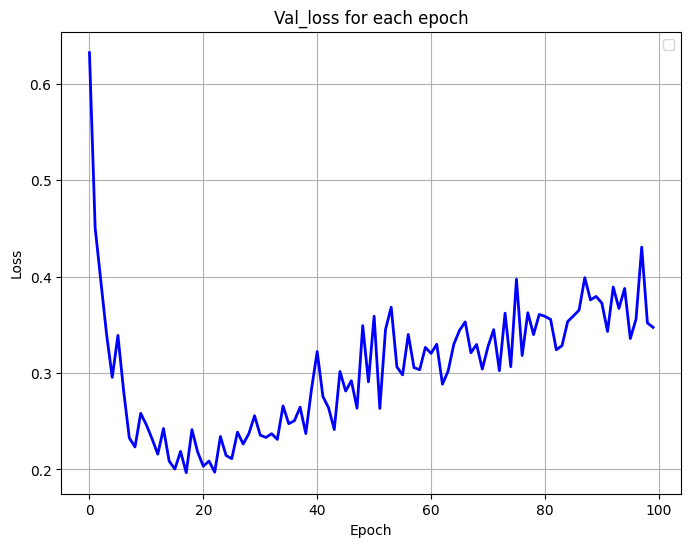

In [ ]:
print(val_loss_calculate)
print(len(val_loss_calculate))

i = num_epoch
x = np.array(list(range(i)))
y = np.array(val_loss_calculate)

plt.figure(figsize=(8, 6))
plt.plot(x, y, color='b', linewidth=2)
plt.title('Val_loss for each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)

In [ ]:
# 稍微观察一下 迁移学习训练 后的 模型 样子
print(model)

MLP_Net(
  (fc1): Linear(in_features=129, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=16, bias=True)
)


In [ ]:
print("The size of encoded label is:")
print(y_test_C.size())
print(y_test_C)
print("\n")

Output = model(X_test_C)
print("The size of output is:")
print(Output.size())
print(Output)
print("\n")

Pred = Output.argmax(axis=1)
print("The size of predicted value is:")
print(Pred.size())
print(Pred)
print("\n")

print("The confusion matrix is:")
print(confusion_matrix(y_test_C, Pred))
print("\n")

print("The overall f1 score list is:")
F1 = f1_score(y_test_C, Pred, average=None)
print(F1)

print("\n")

print("The overall f1 score is:")
F2 = f1_score(y_test_C, Pred, average="micro")
print(F2)
print("\n")

print("The f1 score of each label is:")

for label_code, f1 in enumerate(F1):
  original_label = label_decoded_dict[label_code]
  print(f"{original_label}: {f1}")
print("\n")

print("The accuracy is:")
print(f"Train accuracy on test_C.csv: {accuracy_score(y_test_C, Pred) * 100:.2f}%")



The size of encoded label is:
torch.Size([873])
tensor([10., 10., 10.,  1., 10., 10., 10., 14., 10., 10., 10., 10.,  4., 10.,
         9., 10.,  5.,  6., 10., 10.,  8., 10., 10., 10., 10., 15., 12., 10.,
        10., 10., 10.,  0., 11., 10., 10., 13., 10., 10., 10., 10., 10.,  3.,
        10.,  7.,  2., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10.,  8., 10., 10.,  7., 10., 10.,  6., 10.,  5., 12., 10.,
        10., 10., 14.,  2., 10., 10., 10., 10.,  0., 10., 11.,  9., 10.,  4.,
        15., 13.,  1., 10., 10., 10.,  3., 10.,  5., 10., 10.,  8., 10., 12.,
        14., 10., 10., 10.,  3., 10., 10., 10., 10., 10.,  0., 11., 10., 10.,
         6., 10., 10., 10., 10.,  2., 10.,  4., 10., 13.,  7., 10., 10., 10.,
         9., 10., 10., 10., 10., 10., 10.,  1., 10., 10., 10., 15., 10.,  3.,
        10., 10., 10.,  1., 10.,  6., 10.,  9., 10.,  0., 10., 10.,  7., 10.,
        10., 10., 10., 10., 10., 10., 15., 11.,  8., 10., 10., 10., 10., 10.,
        14., 10.

In [ ]:
# save the model
model_save_path = '/content/drive/MyDrive/Model_for_NDT_transfer_learning/model.pth'
torch.save(model.state_dict(), model_save_path)

In [ ]:
# try to load the model
# Specify the path from where you want to load the model on Google Drive
model_2 = MLP_Net()
model_load_path = '/content/drive/MyDrive/Model_for_NDT_transfer_learning/model.pth'

# Load the model from the specified path
model_2.load_state_dict(torch.load(model_load_path))

In [ ]:

train_A = pd.concat([label_A, data_input_features_A], axis=1)
train_C = pd.concat([label_C_train, data_input_features_C_train], axis=1)
test_C = pd.concat([label_C_test, data_input_features_C_test], axis=1)

train_A.head()


In [ ]:
train_A.to_csv('drive/My Drive/train_A.csv')
train_C.to_csv('drive/My Drive/train_C.csv')
test_C.to_csv('drive/My Drive/test_C.csv')

In [ ]:
# We ran multiple simulation and write down the performance for different number of selected features
x = np.array([20,40,60,80,100,200,400,600,800,1000,1200,1500,1965])
y = np.array([0.355, 0.572, 0.565, 0.683, 0.777, 0.795, 0.742, 0.774, 0.748, 0.724, 0.727, 0.675, 0.654])

plt.figure(figsize=(8, 6))
plt.plot(x, y, color='b', linewidth=2)
plt.title('Average F1 score for different selected features')
plt.xlabel('The number of selected features')
plt.ylabel('Average F1 score')
plt.legend()

plt.grid(True)

plt.savefig("drive/My Drive/feature.eps", format="eps", dpi=1000)

In [ ]:
# We ran multiple simulation and write down the performance for different number data we use from train_data_C
x = np.array([10,20,30,40,50,60,70,80,90,100])
y = np.array([0.737982, 0.791402, 0.813875, 0.856156, 0.877387, 0.886344, 0.854891, 0.877659, 0.870024, 0.873435])

plt.figure(figsize=(8, 6))
plt.plot(x, y, color='b', linewidth=2)
plt.title('Average F1 score for different volume of training-data_C')
plt.xlabel('The percentage of training-data_C we use(%)')
plt.ylabel('Average F1 score')
plt.legend()

plt.grid(True)